In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder = 'drive/MyDrive/Code/GitHub/CellularAutomata'
import sys
sys.path.insert(1, folder)
import ca_model
import count_pixels_dataset as cpd
import visualisation as vis_ca
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5537955192679186086
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15693578240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5772800112151312199
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
# import importlib
# importlib.reload(ca_model)
# importlib.reload(vis_ca)

In [ ]:
# Type of Run
JustTestingCodeQ = False # If True run everything faster, for Debugging
LoadPreviousModelQ = True # if True we load the model, either for further training or just testing
i_step_load = 200000
RunTrainingQ = False # If True we run the neural network training
RunTestMoviesQ = False # if True, in the end we test an increasing size of inputs
MutateTestingQ = True # if True, during testing we mutate the image
RunTestIncreaseQ = True # if True, in the end we test an increasing size of inputs
SEED_TRAINING = 1
SEED_MOVIES = 1

In [ ]:
# Model Options
model_complexity = 'middle' # 'simplest' 'middle' 'complex'
AddNoiseQ = True # if True then the normal update of the CA has noise added
InitializeRandomQ = True # if True, the initial state of the CA is random
MutateTrainingQ = True # if True, during training we mutate the image to anothe random one
no_channels = '4TimesClasses' # 'SameClasses' '5PlusClasses' '4TimesClasses'
TR_EVOLVE = 50 # Number of time steps to let CA evolve for each input during training
TST_EVOLVE = 50 # Number of time steps to let CA evolve for each input during testing
BATCH_SIZE = 64 # number of images per batch
LR = 1e-3 # initial learning rate
UseLRScheduleQ = True # if True use Adam with a learning rate schedule

In [ ]:
# Task and Dataset
NO_CLASSES = 8 # Number of classes that the CA must distinguish ## 2 3 5 8
limits_classes = [2, 5, 9, 14, 20, 27, 35] # boundaries of the classes. len of this should be NO_CLASSES-1 ## [2]  [2, 8] [2, 5, 8, 12] [1, 2, 3, 5, 7, 10, 13] [2, 5, 9, 14, 20, 27, 35]
MAXPIXELS = 44 # Maximum allowed contiguous pixels for the images ## 10 15 44
RebuildDatasetQ = True # if True we rebuild the dataset
SIZE_DS = 100000 #the number of images on the dataset
H, W = 10, 10 # Height and Width of the images
BOUNDARY_P = 0.4 # the proportion of the dataset devoted to the boundaries of the dataset
SEED_DATASET = 1

In [ ]:
if JustTestingCodeQ:
    TR_NO_ITERATIONS = 500 # number of iterations for the training loop
    EXPORT_EVERY = 100 # number of iterations between each model export
    VISUALISE_EVERY = 50 # number of iteration between each model visualisation
    i_step_verify = [500] # [250, 500]
else:
    TR_NO_ITERATIONS = 500000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [240000, 500000] # [240000, 500000]

    TR_NO_ITERATIONS = 5000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 5000] # [240000, 500000]

    TR_NO_ITERATIONS = 20000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 20000] # [240000, 500000]

    TR_NO_ITERATIONS = 50000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [50000, 100000] # [240000, 500000]

    TR_NO_ITERATIONS = 200000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [100000, 200000] # [240000, 500000]
    
    #
if LoadPreviousModelQ and not RunTrainingQ:
    i_step_verify = [i_step_load]

cb_str = str(limits_classes).replace('[', '').replace(']', '').replace(', ', '_')
ds_str = 'CountDigits{}_H{}_W{}_ClassB{}_MaxPixels{}_BoundP{}_Seed{}'.format(SIZE_DS, H, W, cb_str, MAXPIXELS, int(BOUNDARY_P*100), SEED_DATASET)
id_str = 'CA_{}_ModlComplx{}_AddNoise{}_InitRnd{}_MutTrain{}_Channels{}'.format(ds_str, model_complexity, AddNoiseQ, InitializeRandomQ, MutateTrainingQ, no_channels) # the prefix to all file names which will be use for saving and loading the model
print(id_str)

limits_c_p = [0] + limits_classes + [MAXPIXELS]
if NO_CLASSES == 2:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 3:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 5:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 8:
    color_lookup = tf.constant([
                        [85, 85, 85], #These are the colors for the different classes
                        [255, 0, 0], 
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [255, 0, 255],
                        [170, 170, 170],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])

if no_channels == 'SameClasses':
    NO_CHANNELS = NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '4TimesClasses':
    NO_CHANNELS = 4 * NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '5PlusClasses':
    NO_CHANNELS = 5 + NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs

if UseLRScheduleQ:
    first_point = int(TR_NO_ITERATIONS*0.3333)
    second_point = int(TR_NO_ITERATIONS*0.6667)
    if LoadPreviousModelQ and RunTrainingQ:
        if i_step_load > second_point:
            trainer = tf.keras.optimizers.Adam(learning_rate=LR*0.01) # use ADAM optimizer
        elif i_step_load > first_point:
            remaining_steps = TR_NO_ITERATIONS - i_step_load
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (second_point - i_step_load)], [LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
            trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
        else:
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (first_point - i_step_load), 2 * (second_point - i_step_load)], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    else:
        lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2*first_point, 2*second_point], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
else:
    trainer = tf.keras.optimizers.Adam(learning_rate=LR) # use ADAM optimizer

loss_log = np.zeros(TR_NO_ITERATIONS) # for plotting of loss function across time
loss_log_classes = np.zeros((TR_NO_ITERATIONS, NO_CLASSES)) # for plotting of loss function across time

CA_CountDigits100000_H10_W10_ClassB2_5_9_14_20_27_35_MaxPixels44_BoundP40_Seed1_ModlComplxmiddle_AddNoiseTrue_InitRndTrue_MutTrainTrue_Channels4TimesClasses


1


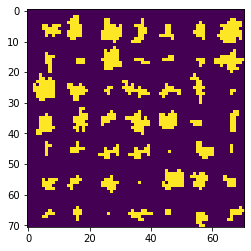

In [ ]:
# Prepare the dataset
BuildDS = False
if RebuildDatasetQ:
    BuildDS = True
else:
    try:
        res = np.load(folder + '/dataset/{}.npz'.format(ds_str))
        x_train, x_test, y_train, y_test = res['x_train'], res['x_test'], res['y_train'], res['y_test']
    except:
        BuildDS = True
if BuildDS:
    x_train, x_test, y_train, y_test = cpd.build_dataset(SIZE_DS, H, W, limits_classes, max_pixels=MAXPIXELS, boundary_p=BOUNDARY_P)
    np.savez(folder + '/dataset/{}.npz'.format(ds_str), x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

    cols=7
    rows=7
    fig, ax = plt.subplots()
    DISP = np.zeros((1, cols * W + 1))
    for i in range(rows):
        disp = np.zeros((H, 1))
        for j in range(cols):
            disp = np.hstack((disp, x_train[np.random.randint(int(SIZE_DS/10)), :, :]))
        DISP = np.vstack((DISP, disp))
    ax.imshow(DISP)

    print(np.prod((np.sum(x_train, axis=(1, 2)) == y_train) * 1))

y_train_pic = cpd.to_classes_dim_label(x_train, y_train, limits_classes)
y_label_train = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_label_train[i] = cpd.class_indice_f(y_train[i], limits_classes)

In [ ]:
if LoadPreviousModelQ:
    ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_load, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)
    ITER = i_step_load + 1
else:
    ca = ca_model.CAModel(NO_CHANNELS, NO_CLASSES, H, W, add_noise=AddNoiseQ, model_complexity=model_complexity)
    ITER = 0

In [ ]:
ca.update_state.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 10, 10, 40)           11920     
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 10, 10, 32)           1312      
Total params: 13,232
Trainable params: 13,232
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training happens here
np.random.seed(SEED_TRAINING)
if RunTrainingQ:
    # Training Loop
    for i in range(ITER, TR_NO_ITERATIONS):
        b_idx = np.random.randint(x_train.shape[0], size=BATCH_SIZE)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_train[b_idx])
        else:
            x0 = ca.initialize(x_train[b_idx])
        y0 = y_train_pic[b_idx]
        y0_label = y_label_train[b_idx]
        y0_label = tf.convert_to_tensor(y0_label)        

        x, loss, c_l = ca_model.train_step(trainer, ca, x0, y0, y0_label, TR_EVOLVE, NO_CLASSES, MutateTrainingQ=MutateTrainingQ)

        loss_log[i] = loss.numpy()
        loss_log_classes[i, :] = [k.numpy() for k in c_l]

        if i % VISUALISE_EVERY == 0:
            clear_output()
            vis_ca.plot_loss(loss_log[:i], loss_log_classes[:i, :], folder, id_str, limits_c_p, color_lookup, True)
        if i % EXPORT_EVERY == 0:
            ca_model.export_model(folder, id_str, ca, i, loss_log, loss_log_classes)

        if NO_CLASSES > 5:
            print('\r step: {}, log10(loss): {}'.format(i + 1, np.log10(loss)), end='')
        else:
            print('\r step: {}, log10(loss): {}, log10(loss)[classes]: {}'.format(i + 1, np.log10(loss), np.log10(c_l)), end='')
    ca_model.export_model(folder, id_str, ca, TR_NO_ITERATIONS, loss_log, loss_log_classes)

In [ ]:
if RunTestMoviesQ:
    eval_bs = 10 ** 2 # number of samples to show in the movie
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)

        np.random.seed(SEED_MOVIES)

        new_idx = np.random.randint(0, x_test.shape[0] - 1, size=eval_bs)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_test[new_idx])
        else:
            x0 = ca.initialize(x_test[new_idx])

        vis_ca.make_run_videos(folder, id_str, i_step_v, TST_EVOLVE, MutateTestingQ, x0, ca, color_lookup)

In [ ]:
if RunTestIncreaseQ:
    eval_bs = 10 ** 2 # number of samples to show in the movie
    max_size = MAXPIXELS

    images = np.zeros((max_size, eval_bs, H, W), dtype=np.float32)
    for i_img in range(eval_bs):
        images[0, i_img, int(H / 2), int(W / 2)] = 1
    for j in range(1, max_size):
        for i_img in range(eval_bs):
            images[j, i_img, :, :] = vis_ca.add_pixel(images[j - 1, i_img, :, :])
    images = tf.constant(images)
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)
        vis_ca.make_videos_increase(folder, id_str, i_step_v, TST_EVOLVE, ca, color_lookup, images, InitializeRandomQ, limits_classes)

100%|██████████| 50/50 [00:00<00:00, 101.31it/s]


In [ ]:
import IPython.display

IPython.display.HTML('''
<script src="https://unpkg.com/@tensorflow/tfjs@latest/dist/tf.min.js\"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/cash/4.1.2/cash.min.js"></script>
<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>
<script>
    "use strict";
    const main = async () => {
        
    }
    main();
</script>''')

In [ ]:
# data_js = '''
#   window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
#   window.SAMPLES = %s
# '''%(model_str, samples_str)

# display(IPython.display.Javascript(data_js))


const main = async () => {

  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));
  
  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        const shape = v.tensorShape.dim.map(d=>parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          arr.fill(v[field][0]);
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  let paused = false;
  let visibleChannel = -1;
  let firingChance = 0.5;
  let drawRadius = 2.5;

  $('#brushSlider').on('input', e=>{
      drawRadius = parseFloat(e.target.value)/2.0;
      $('#radius').text(drawRadius);
  });

  const colorLookup = tf.tensor([
      [128, 0, 0],
      [230, 25, 75],
      [70, 240, 240],
      [210, 245, 60],
      [250, 190, 190],
      [170, 110, 40],
      [170, 255, 195],
      [165, 163, 159],
      [0, 128, 128],
      [128, 128, 0],
      [0, 0, 0], // This is the default for digits.
      [255, 255, 255] // This is the background.
      ])

  let backgroundWhite = true;


  const run = async () => {
      const r = await fetch(GRAPH_URL);
      const consts = parseConsts(await r.json());

      const model = await tf.loadGraphModel(GRAPH_URL);

      const samples = tf.tensor(SAMPLES);
      console.log(samples.shape);
      console.log("Loaded model")
      Object.assign(model.weights, consts);
      const D = 28 * 2;
      const state = tf.variable(tf.zeros([1, D, D, 20]));
      const [_, h, w, ch] = state.shape;

      const scale = 8;

      const canvas = document.getElementById('canvas');
      const ctx = canvas.getContext('2d');
      canvas.width = w * scale;
      canvas.height = h * scale;

      const drawing_canvas = new OffscreenCanvas(w, h);
      const draw_ctx = drawing_canvas.getContext('2d');

      
      let arr = new Float32Array(h * w * 2);
      arr.fill(0.01);
      const blackAndWhiteFull = tf.tensor(arr, [1,h,w,2], tf.float32)

      const drawCanvas = (imgd, e) => {
          var matrix = [];
          for(let i=0; i<imgd.width; i++) {
              matrix[i] = [];
              for(let j=0; j<imgd.height; j++) {
                  let intensity = imgd.data[(imgd.height*j*4 + i*4)];
                  // For drawing, we want to add shades of grey. For erasing, we don't.
                  if (!e.shiftKey) {
                    intensity *= (imgd.data[(imgd.height*j*4 + i*4 + 3)] / 255);
                  }
                  matrix[i][j] = intensity;
              }
          }

          tf.tidy(() => {
              const stroke = tf.tensor(matrix).transpose().toFloat().div(255.).expandDims(0).expandDims(3);
              const stroke_pad = tf.concat([stroke, tf.zeros([1, h, w, ch-1])], 3);
              const mask = tf.tensor(1.).sub(stroke);
              if (e.shiftKey) {
                  state.assign(state.mul(mask));
              } else {
                  state.assign(state.mul(mask).add(stroke_pad));
              }
          });

          // Then clear the canvas.
          draw_ctx.clearRect(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
      }

      const line = (x0, y0, x1, y1, r, e) => {
          draw_ctx.beginPath();
          draw_ctx.moveTo(x0, y0);
          draw_ctx.lineTo(x1, y1);
          draw_ctx.strokeStyle = "#ff0000";
          // Erasing has a much larger radius.
          draw_ctx.lineWidth = (e.shiftKey ? 5. * r : r);
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }


      const circle = (x, y, r, e) => {
          draw_ctx.beginPath();

          const drawRadius = (e.shiftKey ? 5. * r : r) / 3.;

          draw_ctx.arc(x, y, drawRadius, 0, 2 * Math.PI, false);
          draw_ctx.fillStyle = "#ff0000";
          draw_ctx.fill();
          draw_ctx.lineWidth = 1;
          draw_ctx.strokeStyle = "#ff0000";
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }

      const draw_r = 2.0;


      const getClickPos = e =>{
          const x = Math.floor((e.pageX-e.target.offsetLeft) / scale);
          const y = Math.floor((e.pageY-e.target.offsetTop) / scale);
          return [x, y];
      }

      let lastX = 0;
      let lastY = 0;

      canvas.onmousedown = e => {
          const [x, y] = getClickPos(e);
          lastX = x;
          lastY = y;
          circle(x,y,drawRadius, e);
      }
      canvas.onmousemove = e => {
          const [x, y] = getClickPos(e);
          if (e.buttons == 1) {
              line(lastX,lastY, x,y,drawRadius, e);
          }
          lastX = x;
          lastY = y;
      }
      const render = async () => {
        if (!paused) {
          tf.tidy(() => {
              state.assign(model.execute(
                { x: state,
                  fire_rate: tf.tensor(firingChance),
                  manual_noise: tf.randomNormal([1, h, w, ch-1], 0., 0.02)},
                ['Identity']));
          });
        }
        const imageData = tf.tidy(() => {
            let rgbaBytes;
            let rgba;
            if (visibleChannel < 0) {
                const isGray = state.slice([0,0,0,0],[1, h, w, 1]).greater(0.1).toFloat();
                const isNotGray = tf.tensor(1.).sub(isGray);

                const bnwOrder = backgroundWhite ?  [isGray, isNotGray] : [isNotGray, isGray];
                let blackAndWhite = blackAndWhiteFull.mul(tf.concat(bnwOrder, 3));

                const grey = state.gather([0], 3).mul(255);
                const rgb = tf.gather(colorLookup,
                                      tf.argMax(
                                      tf.concat([
                  state.slice([0,0,0,ch-10],[1,h,w,10]),
                  blackAndWhite], 3), 3));

                rgba = tf.concat([rgb, grey], 3)
            } else {
                rgba = state.gather([visibleChannel, visibleChannel, visibleChannel], 3)
                  .pad([[0, 0], [0, 0], [0, 0], [0, 1]], 1).mul(255);
            }
            rgbaBytes = new Uint8ClampedArray(rgba.dataSync());

            return new ImageData(rgbaBytes, w, h);
        });
        const image = await createImageBitmap(imageData);
        //ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillStyle = backgroundWhite ? "#ffffff" : "#000000";
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        ctx.imageSmoothingEnabled = false;
        ctx.drawImage(image, 0, 0, canvas.width, canvas.height);

        requestAnimationFrame(render);
      }
      render();
  }

  run();
}
main();

  



NameError: ignored